# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [ ]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

Check that is works:

In [1]:
import spacy
nlp = spacy.load('en_core_web_md')

def embed(text: str):
    return nlp(line['Question']).vector

2023-04-30 13:45:09.129969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0.a. ARM case 

Probably by the day of your lab the issue is not fixed. Then use `fasttext` of whatever.

In [ ]:
!pip install fasttext

In [ ]:
import fasttext, fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')

def embed(text: str):
    return ft.get_sentence_vector(text)

# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [9]:
!pip uninstall nmslib -y
!pip install nmslib --no-binary :all:

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
  Using cached nmslib-2.1.1.tar.gz (188 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 1.5 MB/s eta 0:00:00 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

Check it works:

In [10]:
import nmslib

# Generate some vectors 

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [2]:
MAX = 30000
DATASET_FILENAME = 'JEOPARDY_CSV.csv'

In [3]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)
        
print("Strings:", len(strings))

Strings: 30000


In [4]:
import tqdm
import pickle
import os

# if vector dimension is different - please change
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):
        vectors[i, :] = embed(line['Question'])
    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

100%|████████████████████████████████████| 30000/30000 [03:10<00:00, 157.62it/s]


 dumping ... done


In [5]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [7]:
!pip3 install nmslib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 1.8 MB/s eta 0:00:000:00:01m eta 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Using cached psutil-5.9.5-cp36-abi3-macosx_10_9_x86_64.whl (245 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1120 lines of output]
      Dependence list: ['pybind11<2.6.2', 'psutil', "numpy>=1.10.0,<1.17 ; python_version=='2.7'", "numpy>=1.10.0 ; python_version>='3.5'"]
      /usr/local/lib/python3.11/site-packages/setuptools/dist.py:770: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      /usr/local/lib/python3.11/site-packages/setuptools/installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installe

      ./similarity_search/src/method/pivot_neighb_invindx.cc:446:31: warning: comparison of integers of different signs: 'std::__vector_base<int, std::allocator<int>>::value_type' (aka 'int') and 'std::vector<const similarity::Object *>::size_type' (aka 'unsigned long') [-Wsign-compare]
            CHECK_MSG(pivot_pos_[i] < this->data_.size(),
                      ~~~~~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~
      ./similarity_search/include/logging.h:130:9: note: expanded from macro 'CHECK_MSG'
        if (!(condition)) {\
              ^~~~~~~~~
      ./similarity_search/src/method/pivot_neighb_invindx.cc:793:16: note: in instantiation of member function 'similarity::PivotNeighbInvertedIndex<int>::LoadIndex' requested here
      template class PivotNeighbInvertedIndex<int>;
                     ^
      ./similarity_search/src/method/pivot_neighb_invindx.cc:674:37: warning: comparison of integers of different signs: 'int_fast32_t' (aka 'int') and 'const size_t' (aka 'const unsigned long') [-Ws

Failed to build nmslib
  Running setup.py install for nmslib ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for nmslib did not run successfully.
  │ exit code: 1
  ╰─> [1115 lines of output]
      Dependence list: ['pybind11<2.6.2', 'psutil', "numpy>=1.10.0,<1.17 ; python_version=='2.7'", "numpy>=1.10.0 ; python_version>='3.5'"]
      /usr/local/lib/python3.11/site-packages/setuptools/dist.py:770: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      running install
      /usr/local/lib/python3.11/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_ext
      clang -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -I/usr/l

          if (frame && (std::string) str(frame->f_code->co_name) == name &&
                                              ^
      /usr/local/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/include/python3.11/pytypedefs.h:22:16: note: forward declaration of '_frame'
      typedef struct _frame PyFrameObject;
                     ^
      In file included from nmslib.cc:16:
      /usr/local/lib/python3.11/site-packages/pybind11/include/pybind11/pybind11.h:2220:14: error: member access into incomplete type 'PyFrameObject' (aka '_frame')
              frame->f_code->co_argcount > 0) {
                   ^
      /usr/local/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/include/python3.11/pytypedefs.h:22:16: note: forward declaration of '_frame'
      typedef struct _frame PyFrameObject;
                     ^
      In file included from nmslib.cc:16:
      /usr/local/lib/python3.11/site-packages/pybind11/include/pybind11/pybind11.h:2223:18: error: member access into inco

In [12]:
import nmslib

def get_index(
        vectors, 
        method='hnsw', 
        space='cosinesimil', 
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()
    
    if cutoff is not None:
        vectors = vectors[:cutoff]
    
    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        # this parameter appies to HNSW only
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index


# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    ids, dists = index.knnQuery(vector, k=nn)
    return list(ids)


# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    result = index.knnQueryBatch(batch, k=nn, num_threads=8)
    return [list(k[0]) for k in result]

## Construct buckets with ground truth

In [13]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra', 
          'cooking', 'armory', 'war', 'history', 'money', 'books', 
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry', 
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [14]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [15]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [16]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [17]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    a = sorted_result[:N]
    b = sorted_ground_truth[:N]
    return len(set(a).intersection(b)) / N

In [18]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Discuss the values.
- Why do you see these numbers? 
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [19]:
hnsw = get_index(vectors, method='hnsw')


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
****************************************************


In [20]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@100 = 0.84
recall@1000 = 0.351
recall@2000 = 0.1755


Discuss: why recall drops with the growth of N?

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [21]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [22]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()
    I = get_index(
        vectors, 
        method='hnsw',
        efConstruction=ef,
        efSearch=ef,
        M=M,
        cutoff=D
    )
    build_time = time.time() - start
    
    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.
    
    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)
    
    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results) 
    
    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

  0%|                                                    | 0/60 [00:00<?, ?it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
  2%|▋                                           | 1/60 [00:00<00:42,  1.40it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
  3%|█▍                                          | 2/60 [00:01<00:40,  1.44it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|--

 37%|███████████████▊                           | 22/60 [00:54<01:06,  1.76s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
****************************************************
 38%|████████████████▍                          | 23/60 [00:57<01:09,  1.88s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
 40%|█████████████████▏                         | 24/60 [00:59<01:14,  2.08s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   

 75%|████████████████████████████████▎          | 45/60 [02:31<01:36,  6.46s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
 77%|████████████████████████████████▉          | 46/60 [02:32<01:06,  4.75s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
 78%|█████████████████████████████████▋         | 47/60 [02:32<00:45,  3.53s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|--

In [23]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", 
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,0.467615,0.038722,0.085102,0.900495,0.267383,0.900495
1,8,2000,200,0.429569,0.037892,0.080064,0.900940,0.269420,0.900940
2,8,2000,400,0.451842,0.036254,0.090666,0.903165,0.271170,0.903165
3,8,5000,100,1.139429,0.058793,0.095673,0.879220,0.299006,0.879220
4,8,5000,200,0.868626,0.041395,0.091881,0.879795,0.300050,0.879795
5,8,5000,400,0.874780,0.040935,0.091967,0.879580,0.299306,0.879580
6,8,10000,100,1.981712,0.051191,0.107059,0.864490,0.304898,0.864490
7,8,10000,200,1.574275,0.049664,0.110672,0.864005,0.304644,0.864005
8,8,10000,400,1.661448,0.059142,0.135135,0.864715,0.305868,0.864715
9,8,20000,100,3.958481,0.065838,0.150777,0.848300,0.306428,0.848300


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [24]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

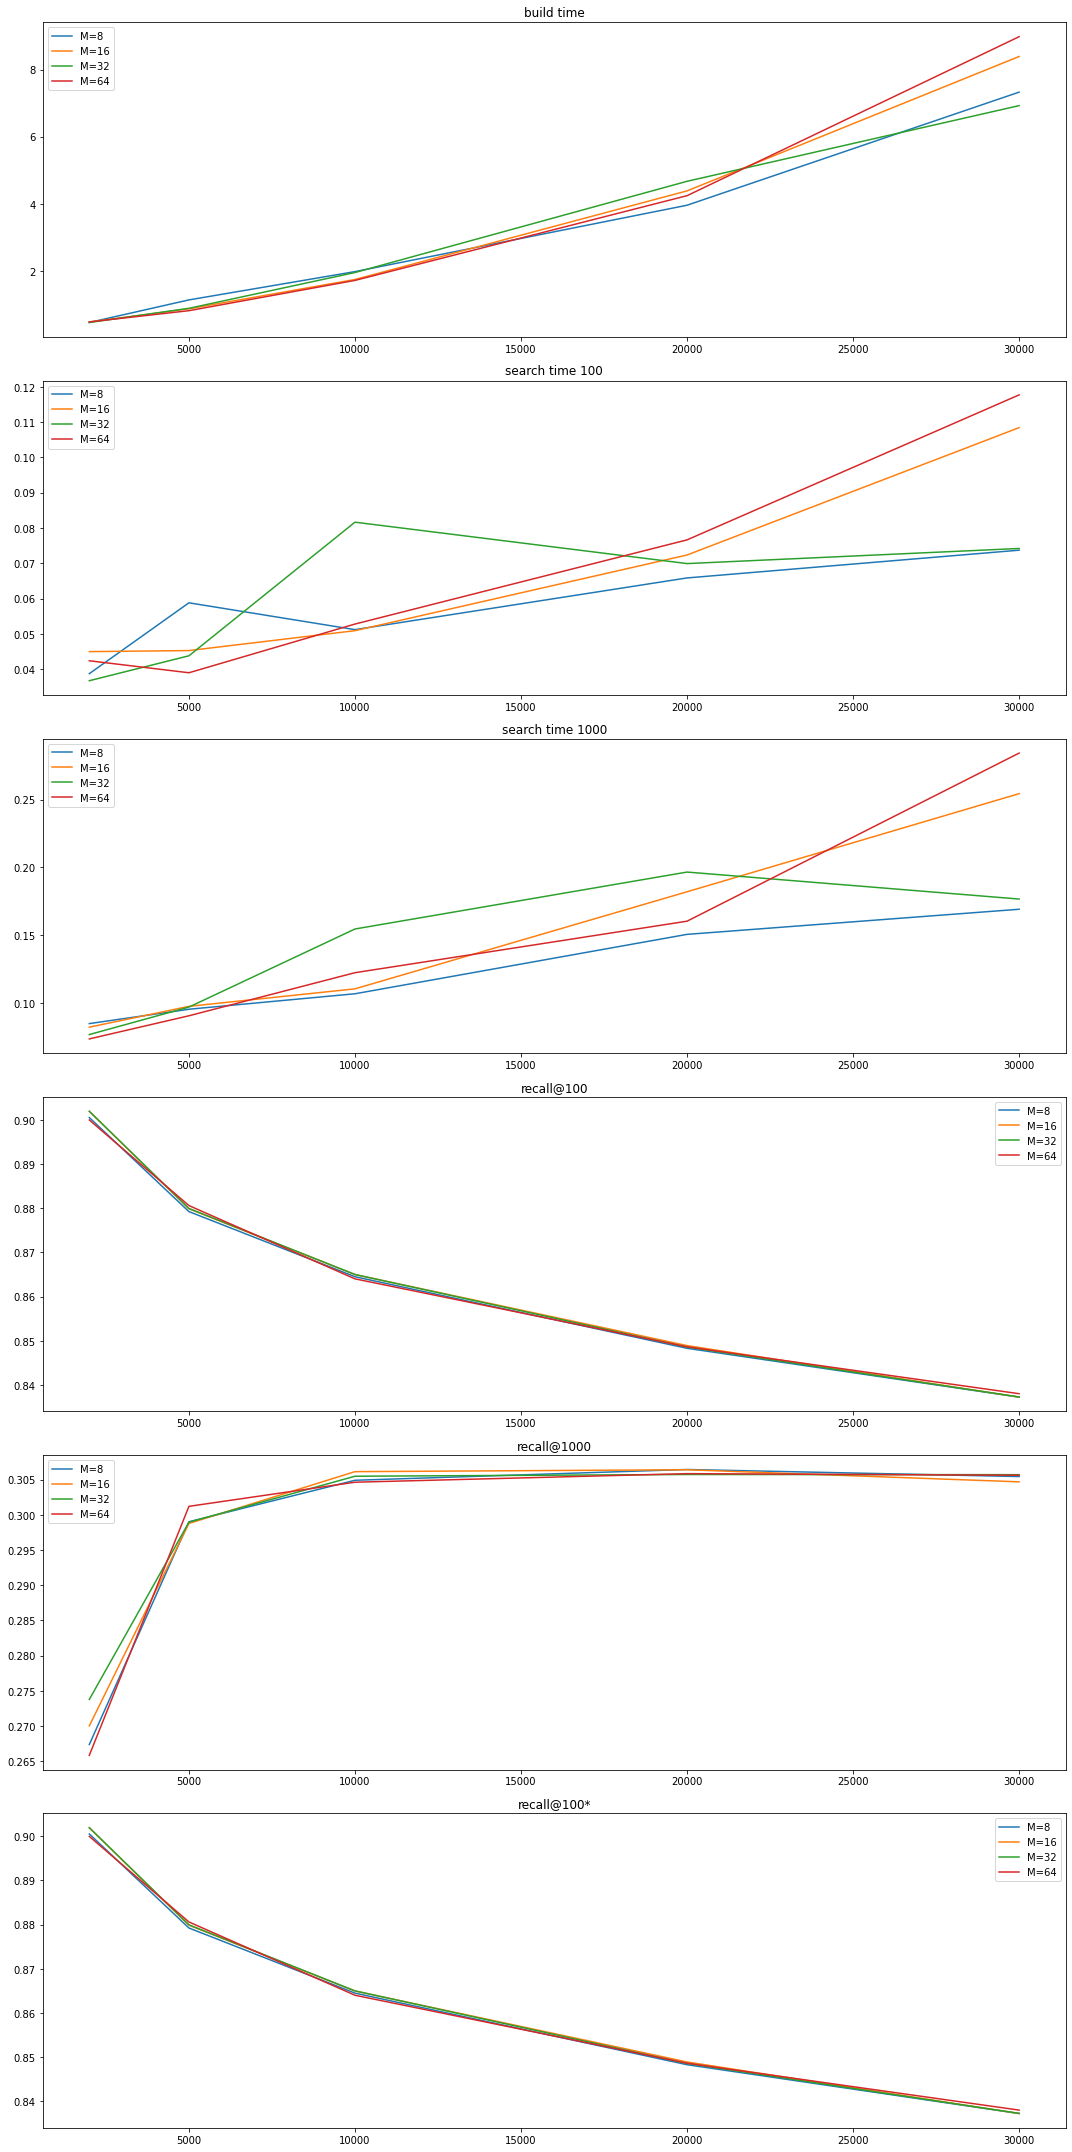

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()
        
plt.tight_layout()
plt.show()